In [270]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


In [271]:
edades = (237_485, 235_380, 232_698, 232_977, 240_355, 253_783, 259_286, 255_103, 253_727, 257_251, 261_503, 262_813, 261_239, 254_675, 247_390, 242_698, 242_620, 246_540, 251_565, 259_382, 266_643, 273_756, 283_395, 291_567, 300_768, 310_246, 318_988, 326_663, 332_641, 341_333, 348_912, 343_528, 338_009, 321_178, 307_851, 298_657, 293_724, 291_770, 290_265, 286_689, 280_255, 273_917, 270_158, 268_754, 269_088, 268_587, 266_068, 260_328, 253_588, 247_710, 244_691, 244_147, 245_405, 245_947, 244_820, 242_282, 238_883, 234_587, 229_184, 222_668, 215_503, 208_478, 202_331, 196_578, 190_654, 183_906, 176_668, 169_205, 161_590, 152_966, 143_648, 129_832, 120_013, 114_500, 107_347, 99_567, 92_332, 85_583, 79_607, 73_865, 68_375, 62_863, 57_395, 51_928, 46_500, 41_516, 37_071, 33_277, 29_818, 26_522, 23_249, 19_957, 16_691, 13_490, 10_581, 8_115, 6_041, 4_400, 3_134, 2_206, 4_941)
Wong = ['#000000', '#E69F00', '#56B4E9',
        '#009E73', '#F0E442', '#0072B2',
        '#D55E00', '#CC79A7']

def get_pobl(start, end):
    """Return the sum of pobl. in a range [start-end] both included"""
    return sum(edades[start:end+1])
print(get_pobl(0,20000))

19678363


In [272]:
casos = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto16/CasosGeneroEtario_T.csv')
casos = casos.drop(0).rename(columns={'Grupo de edad': 'Fecha'}).set_index('Fecha')
casos_H = casos[casos.columns[:int(len(casos.columns)/2)]]
casos_M = casos[casos.columns[int(len(casos.columns)/2):]]
casos_M.columns= casos.columns[:int(len(casos.columns)/2)]
casos_H = casos_H.apply(pd.to_numeric)
casos_M = casos_M.apply(pd.to_numeric)
casos_m = casos_H + casos_M
casos_m.index = pd.to_datetime(casos_m.index)
# print(casos_m.index)
# hay un dia que no hubieron nuevos casos, borrando
casos_m = casos_m.drop(pd.Timestamp('2020-10-02'))
casos_m = casos_m.resample('D').interpolate('quadratic')
# casos_m = casos_m.resample('7D').sum().iloc[:-1].resample('1D').ffill().div(7).rolling(21).mean()

casos_m = casos_m.diff()
# hay un nuevo caso negativo, arreglando
casos_m.loc['2020-04-04']['00 - 04 años'] = 1
casos_m.loc['2020-04-05']['00 - 04 años'] = 0
e0_39 = list(casos_m.columns[:8])
e40_49 = list(casos_m.columns[8:10])
e50_59 = list(casos_m.columns[10:12])
e60_69 = list(casos_m.columns[12:14])
e70_9999 = list(casos_m.columns[14:])
casos_m_edadesUCI = pd.merge(casos_m[e0_39].T.sum().rename('<=39'), casos_m[e40_49].T.sum().rename('40-49'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e50_59].T.sum().rename('50-59'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e60_69].T.sum().rename('60-69'), left_index=True, right_index=True)
casos_m_edadesUCI = pd.merge(casos_m_edadesUCI, casos_m[e70_9999].T.sum().rename('>=70'), left_index=True, right_index=True)
casos_100milhab = casos_m_edadesUCI.copy()
casos_100milhab['<=39'] = casos_100milhab['<=39']/get_pobl(0,39)*100_000
casos_100milhab['40-49'] = casos_100milhab['40-49']/get_pobl(40,49)*100_000
casos_100milhab['50-59'] = casos_100milhab['50-59']/get_pobl(50,59)*100_000
casos_100milhab['60-69'] = casos_100milhab['60-69']/get_pobl(60,69)*100_000
casos_100milhab['>=70'] = casos_100milhab['>=70']/get_pobl(70,1000)*100_000

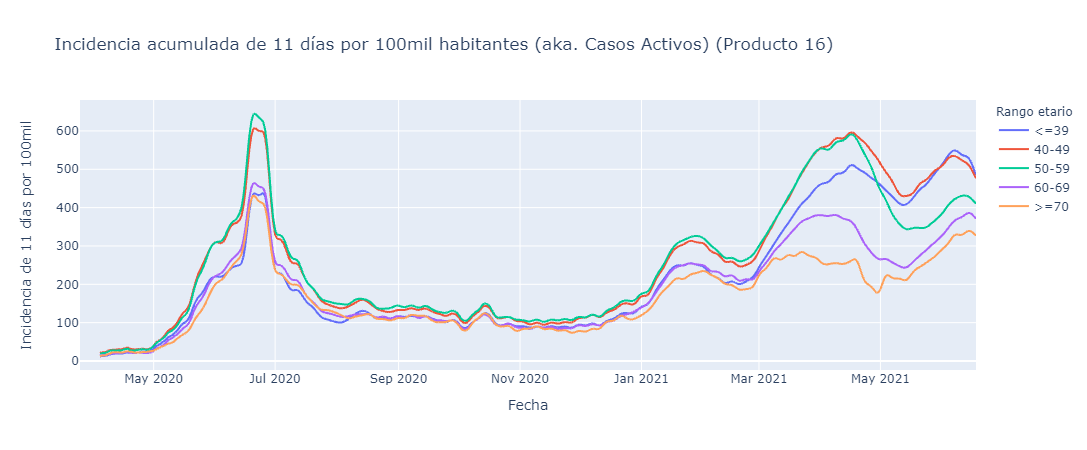

In [274]:
px.line(casos_100milhab.rolling(11).sum(),
        labels={
                     "value": "Incidencia de 11 días por 100mil",
                     "x": "Día",
                     "variable": "Rango etario"
              },
        title="Incidencia acumulada de 11 días por 100mil habitantes (aka. Casos Activos) (Producto 16)")


In [275]:
uci = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto9/HospitalizadosUCIEtario_T.csv')
uci['Grupo de edad'] = pd.to_datetime(uci['Grupo de edad'],infer_datetime_format=True)
uci = uci.rename(columns={'Grupo de edad': 'Fecha'}).set_index('Fecha')
uci

,<=39,40-49,50-59,60-69,>=70
Fecha,,,,,
2020-04-01,23,23,53,39,35
2020-04-02,23,27,67,46,37
2020-04-03,26,34,74,56,47
2020-04-04,40,36,84,68,52
2020-04-05,40,40,89,75,63
...,...,...,...,...,...
2021-06-18,671,563,757,713,479
2021-06-19,666,571,756,715,491
2021-06-20,670,564,747,704,482


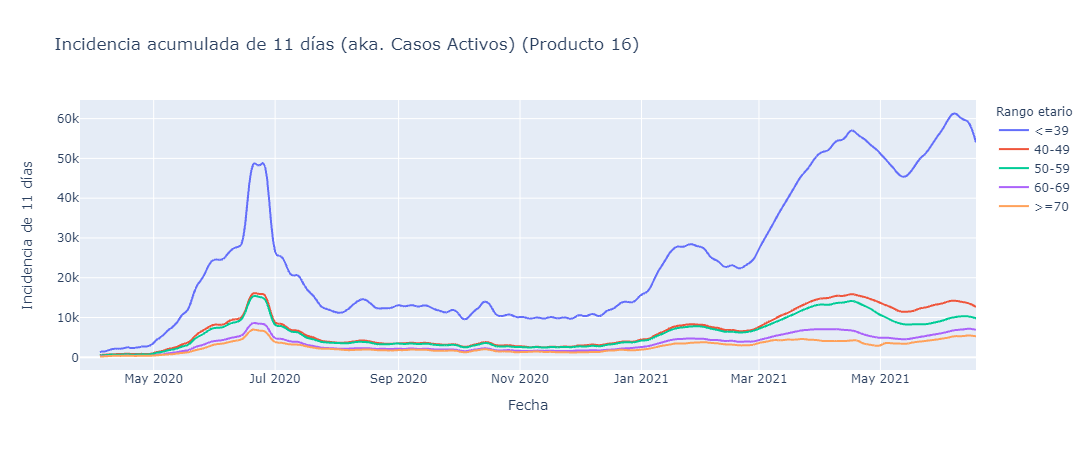

In [276]:
px.line(casos_m_edadesUCI.rolling(11).sum(),
        labels={
                     "value": "Incidencia de 11 días",
                     "x": "Día",
                     "variable": "Rango etario"
              },
        title="Incidencia acumulada de 11 días (aka. Casos Activos) (Producto 16)")


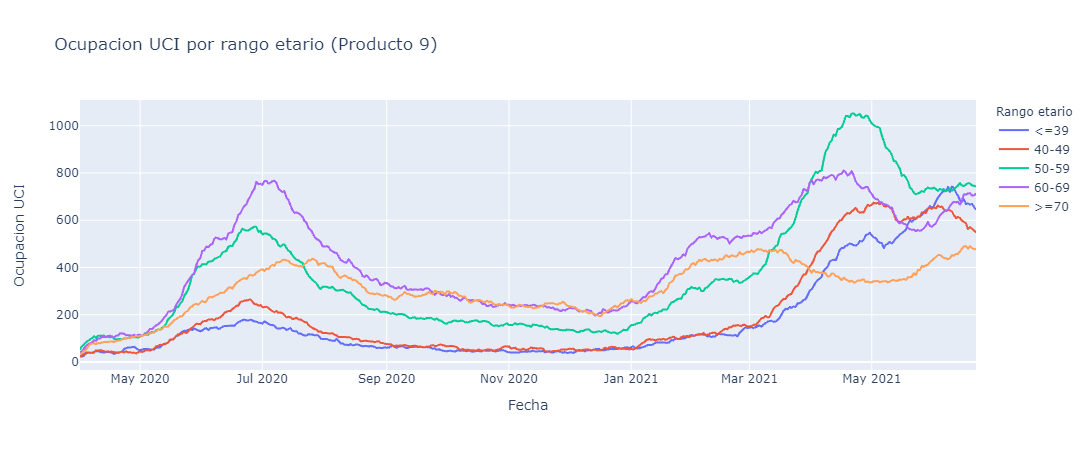

In [277]:
px.line(uci,
        labels={
                     "value": "Ocupacion UCI",
                     "x": "Día",
                     "variable": "Rango etario"
              },
        title="Ocupacion UCI por rango etario (Producto 9)")


In [92]:
uci.shift(-11)

,<=39,40-49,50-59,60-69,>=70
Fecha,,,,,
2020-04-01,41.0,48.0,110.0,106.0,82.0
2020-04-02,40.0,45.0,112.0,106.0,84.0
2020-04-03,42.0,43.0,105.0,105.0,84.0
2020-04-04,42.0,45.0,107.0,110.0,85.0
2020-04-05,41.0,43.0,103.0,111.0,86.0
...,...,...,...,...,...
2021-06-14,NaN,NaN,NaN,NaN,NaN
2021-06-15,NaN,NaN,NaN,NaN,NaN
2021-06-16,NaN,NaN,NaN,NaN,NaN


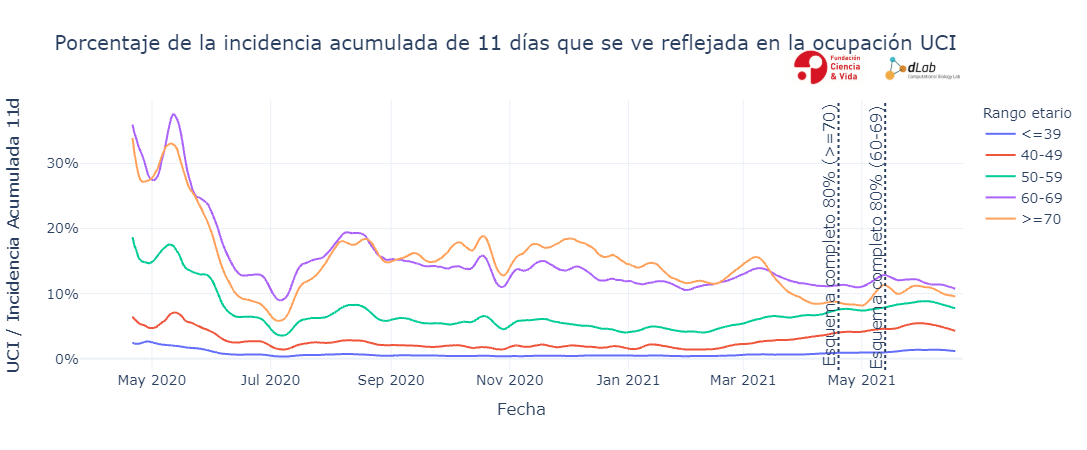

In [278]:
import datetime
uci_activo_pl = px.line(uci.div(casos_m_edadesUCI.rolling(11).sum().shift(11)).rolling(7).mean(),
        labels={
                     "value": "UCI / Incidencia Acumulada 11d",
                     "x": "Día",
                     "variable": "Rango etario"
              },
        title="Porcentaje de la incidencia acumulada de 11 días que se ve reflejada en la ocupación UCI")
uci_activo_pl.update_layout(template='plotly_white')
uci_activo_pl.update_layout(yaxis_tickformat = ',.1f')
uci_activo_pl.update_layout(hovermode="x")

uci_activo_pl.update_layout(
    font=dict(
        size=14,
    )
)
uci_activo_pl.update_traces(
    hovertemplate="<br>".join([
#         "Día: %{x}",
        "%{y:.1%}",
    ])
)
uci_activo_pl.update_layout(yaxis_tickformat = '%{y:.3f}')

uci_activo_pl.add_layout_image(
    dict(
        source="https://i2.wp.com/dlab.cl/wp-content/uploads/2016/08/LogoWebDlab.png",
        xref="paper", yref="paper",
        x=1, y=1.05,
        sizex=0.2, sizey=0.2,
        xanchor="right", yanchor="bottom"
    )
)
uci_activo_pl.add_vline(x=datetime.datetime(2021,4,19).timestamp() * 1000, line_dash="dot",)
#                         annotation_text='Vacunacion del 80% (>=70)',
#                        annotation_position="top left")
uci_activo_pl.add_vline(x=datetime.datetime(2021,5,13).timestamp() * 1000, line_dash="dot",)
#                         annotation_text='Vacunacion del 80% (60-69)')
uci_activo_pl.add_annotation(
    x=datetime.datetime(2021,4,19).timestamp() * 1000,
    y=0.99,
    xref="x",
    yref="y domain",

    text="Esquema completo 80% (>=70)",
    showarrow=False,
    font=dict(
        size=16,
        ),
    xshift=-10,
    arrowhead=1,
    ax=-150,
    ay=-90,
    textangle=-90

)
uci_activo_pl.add_annotation(
    x=datetime.datetime(2021,5,13).timestamp() * 1000,
    y=0.99,
    xref="x",
    yref="y domain",
    text="Esquema completo 80% (60-69)",
    showarrow=False,
    font=dict(
        size=16,
        ),
    xshift=-10,
    arrowhead=1,
    ax=-190,
    ay=-150,
    textangle=-90
)

uci_activo_pl.write_html(f'PorcentajeUCIActivos.html')
uci_activo_pl

In [225]:
(uci.div(casos_m_edadesUCI.rolling(11).sum().shift(11)).rolling(7).mean().loc['2021-05-18':]*100).describe().T

,<=39,40-49,50-59,60-69,>=70
Fecha,,,,,
2021-05-18,1.086125,4.620620,8.225204,12.211160,10.153219
2021-05-19,1.119741,4.686838,8.305875,12.098059,9.984760
2021-05-20,1.155597,4.771886,8.343557,12.038253,9.951697
2021-05-21,1.188552,4.873407,8.387914,12.057105,10.027246
2021-05-22,1.221766,4.987073,8.418588,12.109153,10.198397
2021-05-23,1.252821,5.080999,8.469294,12.129585,10.356711
2021-05-24,1.283260,5.169579,8.497444,12.168437,10.578367
2021-05-25,1.308857,5.245851,8.524541,12.175146,10.784463
2021-05-26,1.325966,5.313041,8.560901,12.199854,10.980043
